# Imports and function definitions (RUN ME!)

In [ ]:
# !pip install opencv-python

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/DL"

data_prep.ipynb			    modeling.ipynb
fused_gaf_sd.zip		    modeling_refactored_hyper.ipynb
fused_images_rp_sd_ankle_wrist.zip  modeling_refactored.ipynb
fused_images_rp_summed_diff.zip     summed_diff_images.zip
hyper_gaf.ipynb


In [3]:
# Defining paths to files
persistence_path = "/content/drive/My Drive/DL/" # TODO: replace me
working_directory = "/content/" # TODO: replace me (or not)

# Image only
zip_image_only_path = persistence_path + 'summed_diff_images.zip'
unzip_image_only_path = working_directory + 'image_only/'

# Image + GAF
zip_gaf_sd_path = persistence_path + 'fused_gaf_sd.zip'
unzip_gaf_sd_path = working_directory + 'fused_gaf_sd/'

# Image + RP (ankle acc, ankle gyro)
fused_images_zip_path = persistence_path + 'fused_images_rp_summed_diff.zip'
unzip_fused_images_path = working_directory + 'fused_images/'

# Image + RP (ankle acc, ankle gyro, wrist acc, wrist gyro)
zip_rp_sd_ankle_wrist_path = persistence_path + 'fused_images_rp_sd_ankle_wrist.zip'
unzip_rp_sd_ankle_wrist_path = working_directory + 'fused_images_rp_sd_ankle_wrist/'

In [4]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check GPU availability
gpus_no = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", gpus_no)
# assert gpus_no >= 1, "You're not using a GPU, are you sure you want to proceed?"

Num GPUs Available:  1


In [5]:
def load_data_from_path(trial_path):
    """
    Function that supports loading both images and already processed fused data
    merged of load_data_from_trial and load_fused_data
    """
    data = []
    labels = []
    skipped_files = []

    for root, _, files in os.walk(trial_path):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                # NOTE: moved this here because idk if file naming strategy is different between plain images and fused
                # it was in the loop above before refactor..
                # Extract activity label from the folder name
                try:
                    folder_name = os.path.basename(root)
                    activity_label = int([part for part in folder_name.split('_') if "Activity" in part][0].replace('Activity', '')) - 1
                except (IndexError, ValueError) as e:
                    skipped_files.append((root, str(e)))
                    continue

                try:
                    # Load the image and normalize to [0, 1]
                    image = plt.imread(file_path) / 255.0
                    data.append(image)
                    labels.append(activity_label)
                except Exception as e:
                    skipped_files.append((file_path, str(e)))

            # NOTE: the part from load_fused is here
            elif file.endswith('.npy'):
                file_path = os.path.join(root, file)
                fused_image = np.load(file_path)

                # Extract activity label from the parent folder structure
                try:
                    folder_name = os.path.basename(root)  # Example: Subject10_Activity10_Trial1
                    activity_part = folder_name.split("_")[1]  # Extracts 'Activity10'
                    activity_label = int(activity_part.replace('Activity', '')) - 1  # Convert to 0-based indexing

                    data.append(fused_image)
                    labels.append(activity_label)
                except (IndexError, ValueError) as e:
                    skipped_files.append((file_path, str(e)))

    # Log skipped files
    if skipped_files:
        print(f"Skipped {len(skipped_files)} files or folders due to errors:")
        for file_path, error in skipped_files[:10]:  # Limit output for clarity
            print(f"File or Folder: {file_path}, Error: {error}")

    return np.array(data), np.array(labels)


def split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path):
    """
    In the dataset, each subject makes three trials of the same activity,

    We use the third trial as test,
    and the first and second trials are merged and then randomly split into train and test sets
    """
    X_trial1, y_trial1 = load_data_from_path(trial1_path)
    X_trial2, y_trial2 = load_data_from_path(trial2_path)
    X_trial3, y_trial3 = load_data_from_path(trial3_path)

    # Combine trial1 and trial2 for training and validation
    X_train_val = np.concatenate((X_trial1, X_trial2), axis=0)
    y_train_val = np.concatenate((y_trial1, y_trial2), axis=0)

    # Use trial3 as the test set
    X_test, y_test = X_trial3, y_trial3

    # Split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Print data shapes
    print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
    print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
    print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def unzip(zip_path, output_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_path)

# Defining models

In [7]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [8]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_model(hp):
    model = Sequential()

    # Dynamically configurable convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 4)):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', 32, 256, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', [3, 5]),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log')),
            input_shape=input_shape if i == 0 else None
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Flatten())

    # Configurable dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', 64, 512, step=64),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'dense_l2_reg_{i}', 1e-4, 1e-2, sampling='log'))
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # Adaptive learning rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Adding more sensor data (SD + RP_ankle + RP_wrist)

In [15]:
unzip(zip_rp_sd_ankle_wrist_path, unzip_rp_sd_ankle_wrist_path)
print("Dataset extracted.")


Dataset extracted.


In [16]:
print(os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial1_fused_images"),)

/content/fused_images_rp_sd_ankle_wrist/fused_images_rp_sd_ankle_wrist/trial1_fused_images


In [17]:
# Paths for each trial
trial_paths = [
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial1_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial2_fused_images"),
    os.path.join(unzip_rp_sd_ankle_wrist_path, 'fused_images_rp_sd_ankle_wrist', "trial3_fused_images")
]

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(*trial_paths)

Training data shape: (3100, 32, 32, 5) Training labels shape: (3100,)
Validation data shape: (776, 32, 32, 5) Validation labels shape: (776,)
Test data shape: (1931, 32, 32, 5) Test labels shape: (1931,)


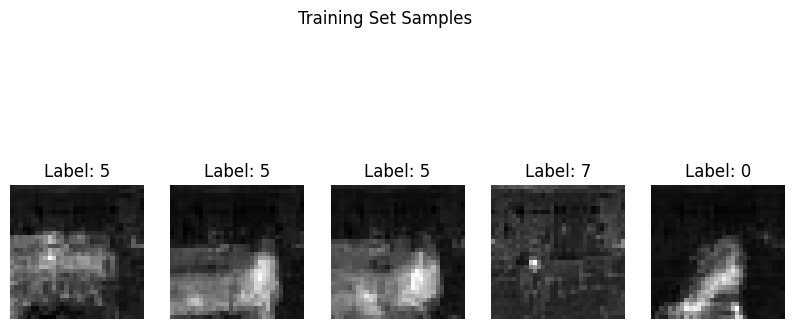

In [19]:
# Function to display random samples
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i][..., 0], cmap='gray')  # Display the first channel
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display training samples
display_random_samples(X_train, y_train, title="Training Set Samples")

In [27]:
# This is important, don't delete
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image

# Tune hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='activity_recognition',
    max_consecutive_failed_trials=100 # ignore whatever parameters that result in an error
)
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
)

# Build final model from the best params and train
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

# Callbacks
checkpoint_path = working_directory + "best_model_rp_sd_ankle_wrist.keras"
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Reloading Tuner from hyperparameter_tuning/activity_recognition/tuner0.json
Best Hyperparameters: {'num_conv_layers': 1, 'conv_0_filters': 96, 'conv_0_kernel': 3, 'l2_reg': 0.004246542656683791, 'dropout_0': 0.5, 'num_dense_layers': 3, 'dense_0_units': 128, 'dense_l2_reg_0': 0.00022535512136146756, 'dense_dropout_0': 0.2, 'learning_rate': 0.00034851460889781614, 'conv_1_filters': 32, 'conv_1_kernel': 3, 'dropout_1': 0.4, 'dense_1_units': 128, 'dense_l2_reg_1': 0.00019352610284264381, 'dense_dropout_1': 0.2, 'conv_2_filters': 192, 'conv_2_kernel': 3, 'dropout_2': 0.5, 'conv_3_filters': 224, 'conv_3_kernel': 3, 'dropout_3': 0.5, 'dense_2_units': 448, 'dense_l2_reg_2': 0.00014151631027858823, 'dense_dropout_2': 0.2, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 96)          │           4,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 15, 15, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 21600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       2,764,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 448)                 │          57,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 11)                  │           4,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,848,587 (10.87 MB)

 Trainable params: 2,848,587 (10.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2861 - loss: 2.8981 - val_accuracy: 0.6057 - val_loss: 1.3017
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5307 - loss: 1.4651 - val_accuracy: 0.7642 - val_loss: 0.8665
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6446 - loss: 1.1446 - val_accuracy: 0.7874 - val_loss: 0.7652
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6949 - loss: 0.9987 - val_accuracy: 0.7912 - val_loss: 0.6637
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7069 - loss: 0.9050 - val_accuracy: 0.7925 - val_loss: 0.6177
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7367 - loss: 0.8319 - val_accuracy: 0.8041 - val_loss: 0.5773
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7593 - loss: 0.7474 - val_accuracy: 0.8080 - val_loss: 0.5531
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7651 - loss: 0.7375 - val_accuracy: 0.8466 -

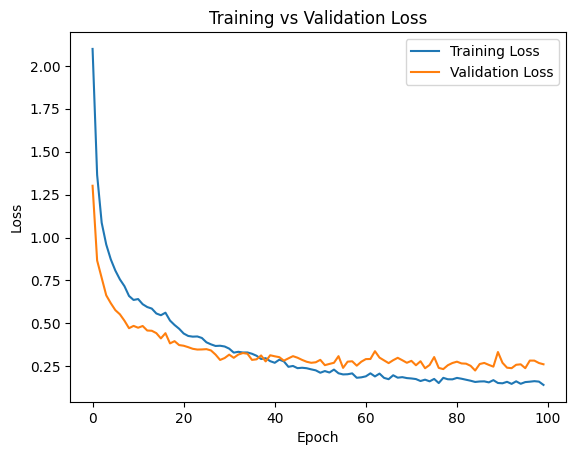

In [32]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.savefig("rp_ankle_wrist_train_val_loss")
plt.show()

In [29]:
best_model.load_weights(checkpoint_path)

# Evaluate on test set
y_pred = best_model.predict(X_test).argmax(axis=1)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71        77
           1       0.70      0.67      0.68        78
           2       0.59      0.47      0.52        81
           3       0.62      0.63      0.63        79
           4       0.57      0.91      0.70        77
           5       0.99      1.00      1.00       336
           6       0.96      0.99      0.97       334
           7       0.98      0.98      0.98       335
           8       0.95      0.84      0.89        73
           9       0.99      1.00      0.99       154
          10       0.96      0.91      0.94       307

    accuracy                           0.91      1931
   macro avg       0.83      0.82      0.82      1931
weighted avg       0.91      0.91      0.91      1931

Confusion Matrix:
[[ 50   8   7   3   4   0   0   0   0   0   5]
 [  7  52   5   9   4   0   0   0   0   0   1]
 

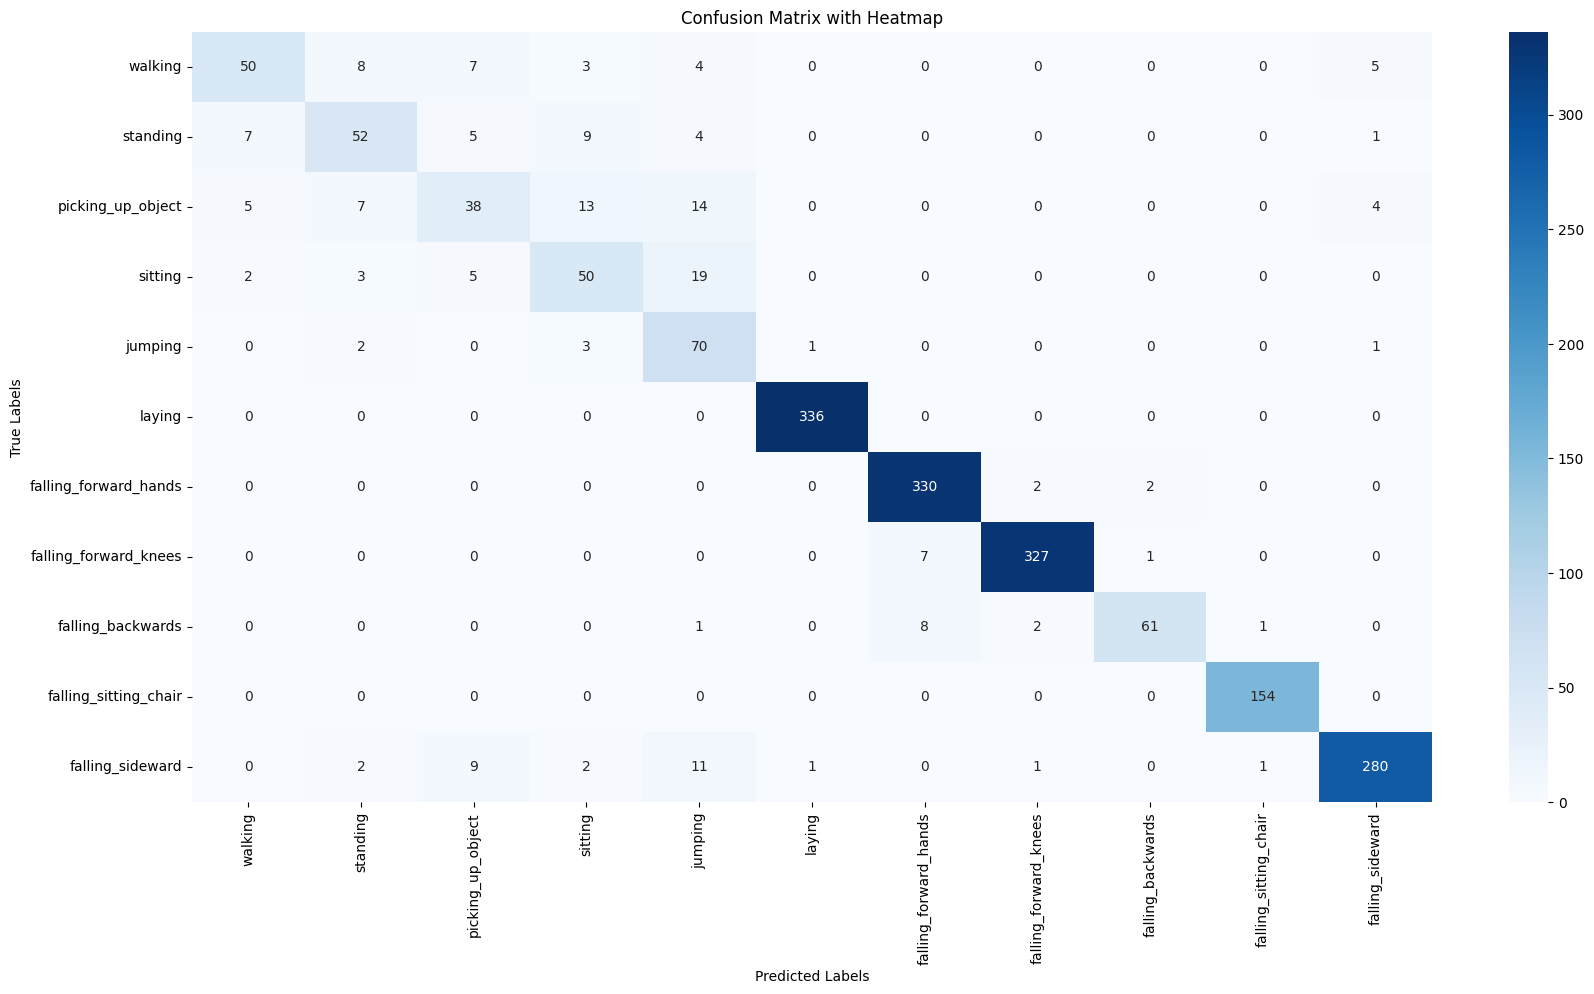

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_names = ['walking',
 'standing',
 'picking_up_object',
 'sitting',
 'jumping',
 'laying',
 'falling_forward_hands',
 'falling_forward_knees',
 'falling_backwards',
 'falling_sitting_chair',
 'falling_sideward']

# Plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix with Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("rp_ankle_wrist_conf_matrix")
plt.show()